In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from collections import Counter

# Read and Prepare data

In [74]:
df = pd.read_csv('data/processed/train_1_processed.csv', index_col=None)

#### Select page

In [75]:
page_index = 10

In [76]:
df = df.loc[[page_index]]

#### Select only time series columns

In [77]:
# Regular expression to match date format "YYYY-MM-DD"
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

# Filter columns based on the regular expression
filtered_columns = [col for col in df.columns if date_pattern.match(col)]

# Create a new DataFrame with only the filtered columns
df = df[filtered_columns]

Save dates for plot later

In [78]:
date_columns = df.columns

In [79]:
df.shape

(1, 550)

#### Split training and test data

In [80]:
# Reshape horizontally for sklearn split
df = df.values.reshape(-1, 1)

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [81]:
# Split dates too
date_columns = np.array(date_columns)
train_dates = date_columns[:len(train_data)]
test_dates = date_columns[len(train_data):len(train_data) + len(test_data)]

#### Missing Values Imputation

Missing values are imputed using forward linear interpolation. NAN values before a certain real value will be filled with 0 and the remaining NAN values will be filled using linear interpolation.

In [82]:
# Transform sets in Pandas data frames to use Pandas interpolation function
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [83]:
train_data = train_data.interpolate(method='linear', limit_direction='forward', axis=0)
test_data = test_data.interpolate(method='linear', limit_direction='forward', axis=0)

#### Normalize

In [84]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

#### Prepare data for LSTM

In [85]:
def create_sequences(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [86]:
timesteps = 7
X_train, y_train = create_sequences(scaled_train_data, timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test_data, timesteps=timesteps)

# Data Modeling

#### Define Multivariate LSTM

In [87]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(timesteps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  # Output layer for a single value
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Train model

In [88]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0047 - val_loss: 0.0298
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0305
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0298
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0298
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0294
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0312
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0297
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0301
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0297
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0300
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0298
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.00

# Data Evaluation

In [89]:
y_pred = model.predict(X_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x14eebcfe0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


In [90]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00397392175989283


In [95]:
# Flatten arrays before inverse transforming
y_test_flat = y_test.reshape(-1, 1)
y_pred_flat = y_pred.reshape(-1, 1)

# Inverse transform to get the original scale
y_test_inv = scaler.inverse_transform(y_test_flat)
y_pred_inv = scaler.inverse_transform(y_pred_flat)

# Convert the date columns to datetime format
test_dates = pd.to_datetime(test_dates)
test_dates = test_dates[timesteps:]  # Adjust dates to match the test period

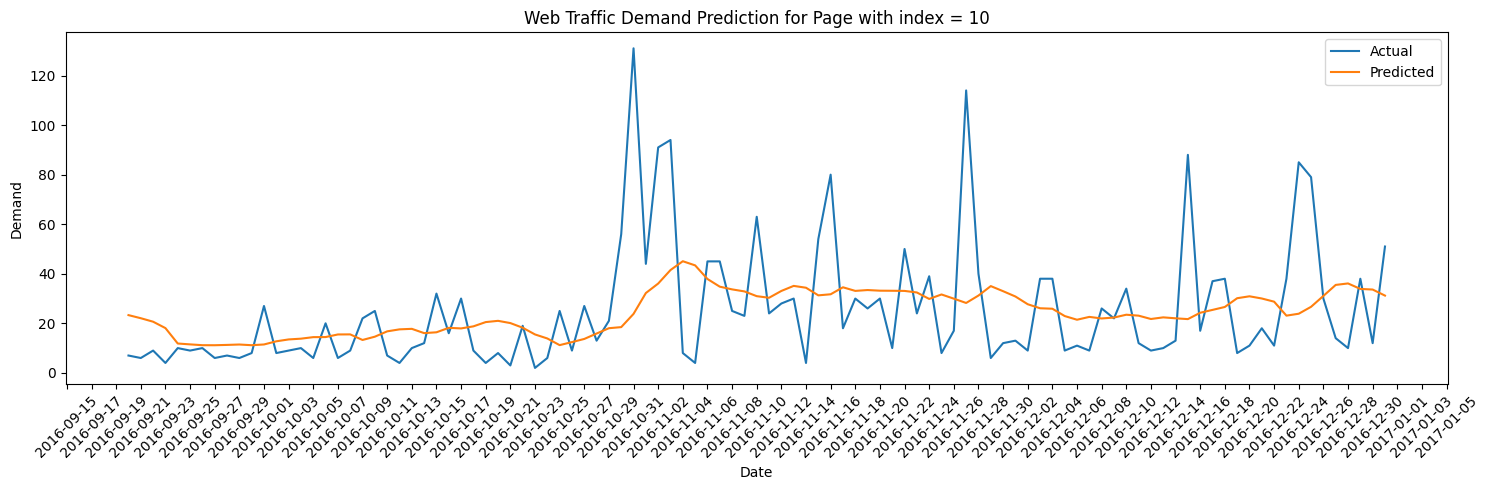

In [98]:
plt.figure(figsize=(15, 5))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()